In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pyaldata

# %load_ext lab_black

# Plot behavior trajectories

In [2]:
from plot_helpers import plot_directions_per_epoch, plot_beh_pred_per_epoch, get_trials2plot, \
                        plot_fourier_AD, plot_fourier_last_sessions #, plot_angular_deviation

In [3]:
area = 'all'
path = f'../../datasets/Chewie_CO_FF_2016-10-07_session_vel_{area}_spikes_go.h5'
data = h5py.File(path, 'r')
data.keys()

<KeysViewHDF5 ['train_behavior', 'train_encod_data', 'train_epoch', 'train_inds', 'train_pos', 'train_recon_data', 'train_target_direction', 'train_vel', 'valid_behavior', 'valid_encod_data', 'valid_epoch', 'valid_inds', 'valid_pos', 'valid_recon_data', 'valid_target_direction', 'valid_vel']>

In [4]:
dset='train'
vel = data[f'{dset}_behavior'][:]
target_direction = data[f'{dset}_target_direction'][:]
epoch = data[f'{dset}_epoch'][:]
spike_data = data[f'{dset}_recon_data'][:]
inds = data[f'{dset}_inds'][:]
testQ = np.zeros_like(epoch)

dset='valid'
vel = np.concatenate([vel,data[f'{dset}_behavior'][:]])
target_direction = np.concatenate([target_direction,data[f'{dset}_target_direction'][:]])
epoch = np.concatenate([epoch,data[f'{dset}_epoch'][:]])
spike_data = np.concatenate([spike_data,data[f'{dset}_recon_data'][:]])
inds = np.concatenate([inds,data[f'{dset}_inds'][:]])
testQ = np.concatenate([testQ,np.ones_like(data[f'{dset}_epoch'][:])])

pos = np.cumsum(vel*0.01,1)

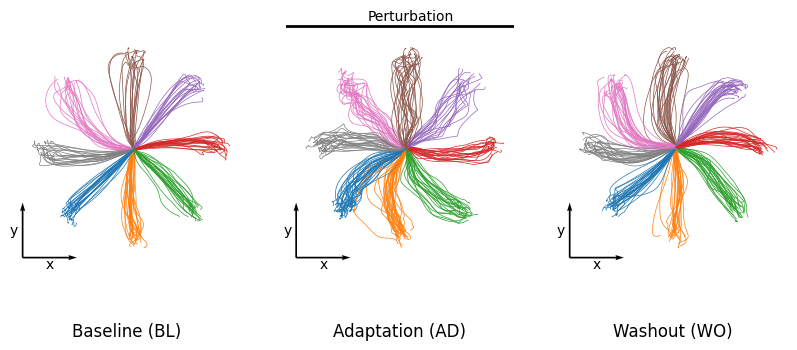

In [5]:
plot_directions_per_epoch(pos,target_direction,epoch)

## Calculate averages

In [6]:
dir_index = np.array([
        sorted(set(target_direction)).index(i) for i in target_direction
    ])
avg_pos = np.empty_like(pos)
avg_vel = np.empty_like(vel)

avg_pos_per_epoch = np.empty_like(pos)
avg_vel_per_epoch = np.empty_like(vel)

for d in range(8):
    mask = (d==dir_index) & (testQ == 0) # avg on train
    avg_pos[mask] = pos[mask].mean(0)
    avg_vel[mask] = vel[mask].mean(0)
    for e in [0,1,2]:
        mask = (d==dir_index) & (e==epoch)
        avg_pos_per_epoch[mask] = pos[mask & (testQ == 0)].mean(0)
        avg_vel_per_epoch[mask] = vel[mask & (testQ == 0)].mean(0)


In [7]:
trials2plot = np.array([get_trials2plot(vel[testQ==1], avg_vel[testQ==1], dir_index[testQ==1], epoch[testQ==1], i) for i in range(3)]).sum(0)
trials2plot.sum()

24

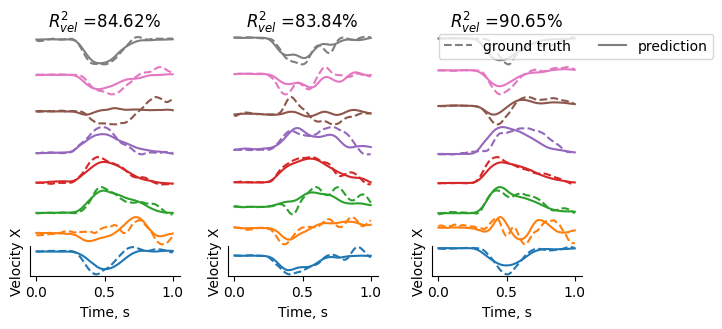

In [8]:
plot_beh_pred_per_epoch(vel[testQ==1], avg_vel_per_epoch[testQ==1], dir_index[testQ==1], trials2plot, epoch[testQ==1],component=0)
# add a horizontal legend saying dashed line -- groud truth, solid line -- prediction
plt.legend(['ground truth','prediction'], loc='lower left', ncols=2)

# Plot spectral analysis

## Set paths

In [9]:
raw_data_dir = (
    "/disk/data1/motor_cortex/perich_2018_binned/"
)
data_save_dir = "../../datasets/"

In [10]:
# just going to hard code this obviously change this if the data changes
experiments = [
    "Chewie_CO_FF_2016-09-15.mat",
    "Chewie_CO_FF_2016-09-21.mat",
    "Chewie_CO_FF_2016-10-05.mat",
    "Chewie_CO_FF_2016-10-07.mat", 
    "Mihili_CO_FF_2014-02-03.mat",  # *
    "Mihili_CO_FF_2014-02-17.mat",  # + (only BL)
    "Mihili_CO_FF_2014-02-18.mat",
    "Mihili_CO_FF_2014-03-07.mat",
]

# experiments = [
#     "Chewie_CO_VR_2016-09-09.mat",
#     "Chewie_CO_VR_2016-09-12.mat",
#     "Chewie_CO_VR_2016-09-14.mat",
#     "Chewie_CO_VR_2016-10-06.mat",
#     "Mihili_CO_VR_2014-03-03.mat",
#     "Mihili_CO_VR_2014-03-04.mat",
#     "Mihili_CO_VR_2014-03-06.mat",
# ]

## Set parameters

In [11]:
"""
activity_key : which neurons to load {"PMd_spikes", "M1_spikes", "all_spikes"}
behaviour_key : behaviour to train to (sometimes assumed to be velocity)
full_behaviour_key : the other behaviour (vel or pos). Here often assumed to be position
alignment : align trials to this point in the experinment. {"go"}
"""
activity_key = "all_spikes" #"PMd_spikes" # "all_spikes" #"M1_spikes"
behaviour_key = "vel"  # the main behavior used in training & validation

trial_len = 100

"""
dt : time step size - this actually depends on the bin window but I cant find where this is set - it is 10ms rn
"""
dt = 0.01


## Summarize velocity oscillations

In [12]:
# load all velocities for all sessions
Vel, Epoch, Target, Trial = {}, {}, {}, {}
idx_go_cue, idx_movement_on, idx_peak_speed, idx_trial_end = {}, {}, {}, {}
for spike_data_dir in experiments:
    
    pd_data = pyaldata.io.mat2dataframe(
        path=raw_data_dir + spike_data_dir, shift_idx_fields=True
    )

    # trials must be successful to be included
    selected_trials = pd_data.loc[
            (pd_data.result == "R") & (pd_data['vel'].apply(lambda x: np.all(np.abs(x) < 100))
        & (pd_data['idx_movement_on'] + trial_len < pd_data['idx_trial_end']))
        ]
    
    Vel[spike_data_dir] = np.asarray(
            [
                d[f'vel'][int(d.idx_movement_on) : int(d.idx_movement_on) + trial_len, :]
                for _, d in selected_trials.iterrows()
            ]
        )
    
    Target[spike_data_dir] = np.asarray(
            [
                d['target_direction']
                for _, d in selected_trials.iterrows()
            ]
        )
    
    Trial[spike_data_dir] = np.asarray(
            [
                d['trial_id']
                for _, d in selected_trials.iterrows()
            ]
        )
    
    # epoch (BL/AD/WO) for each trial
    Epoch[spike_data_dir] = np.asarray(
            [
                d['epoch']
                for _, d in selected_trials.iterrows()
            ]
        )
    
    idx_go_cue[spike_data_dir] = np.asarray(
            [
                d['idx_go_cue']
                for _, d in selected_trials.iterrows()
            ]
    )   

    idx_movement_on[spike_data_dir] = np.asarray(
            [
                d['idx_movement_on']
                for _, d in selected_trials.iterrows()
            ]
    )

    idx_peak_speed[spike_data_dir] = np.asarray(
            [
                d['idx_peak_speed']
                for _, d in selected_trials.iterrows()
            ]
    )   

    idx_trial_end[spike_data_dir] = np.asarray(
            [
                d['idx_trial_end']
                for _, d in selected_trials.iterrows()
            ]
    )

/disk/scratch/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/pandas/core/series.py:1033: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/disk/scratch/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/pandas/core/series.py:1033: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


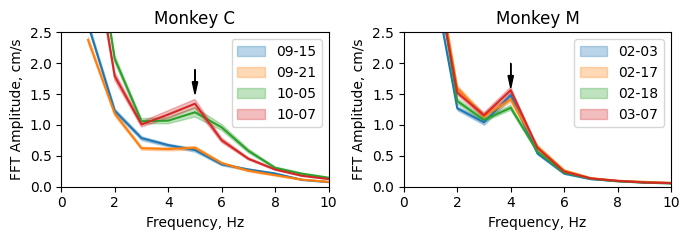

In [13]:
fig, axes = plt.subplots(1,2,figsize=(7,2.5))

plot_fourier_AD(axes, Vel, Epoch, experiments)
plt.tight_layout()

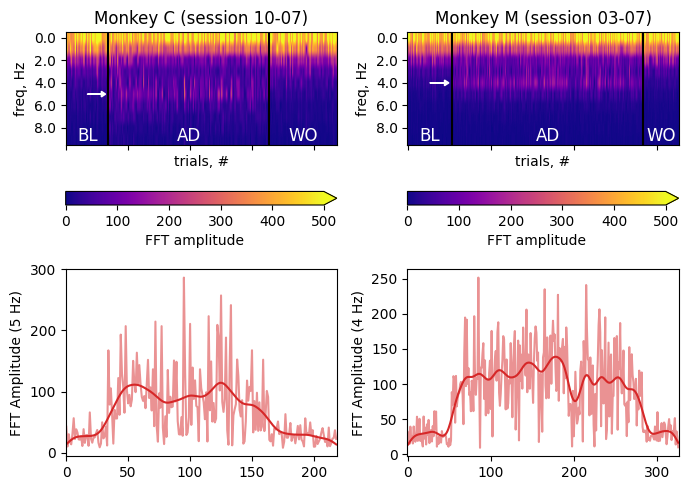

In [14]:
fig, axes = plt.subplots(2,2,figsize=(7,5),sharex='col')

for i, (m, spike_data_dir, peak_fr) in enumerate(zip(['C','M'],[experiments[3],experiments[-1]],[5,4])):
    plot_fourier_last_sessions(axes[0,i], monkey=m, spike_data_dir=spike_data_dir, vel=Vel, epoch=Epoch, plot='spectrum', peak_freq = peak_fr)
    plot_fourier_last_sessions(axes[1,i], monkey=m, spike_data_dir=spike_data_dir, vel=Vel, epoch=Epoch, plot='top_freq', peak_freq = peak_fr, color='C3')
plt.tight_layout()


## figs for supplementary

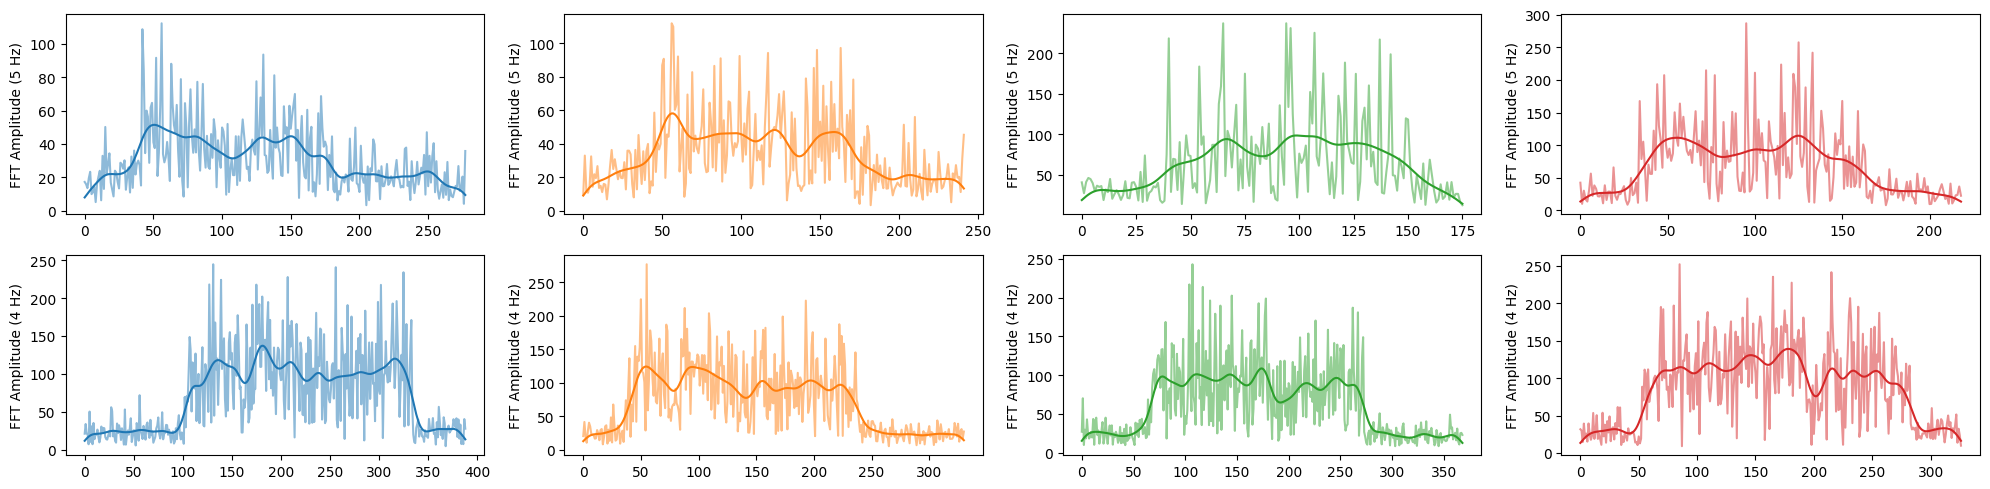

In [15]:

fig, axes = plt.subplots(2,4,figsize=(20,5))

for j, (m, exps, peak_fr) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]],[5,4])):
    for i,spike_data_dir in enumerate(exps):
        plot_fourier_last_sessions(axes[j,i], monkey=m, spike_data_dir=spike_data_dir, vel=Vel, epoch=Epoch, plot='top_freq', peak_freq = peak_fr,color=f'C{i}')
        

plt.tight_layout()
fig.savefig('./figs/Figure3e_sup.pdf')

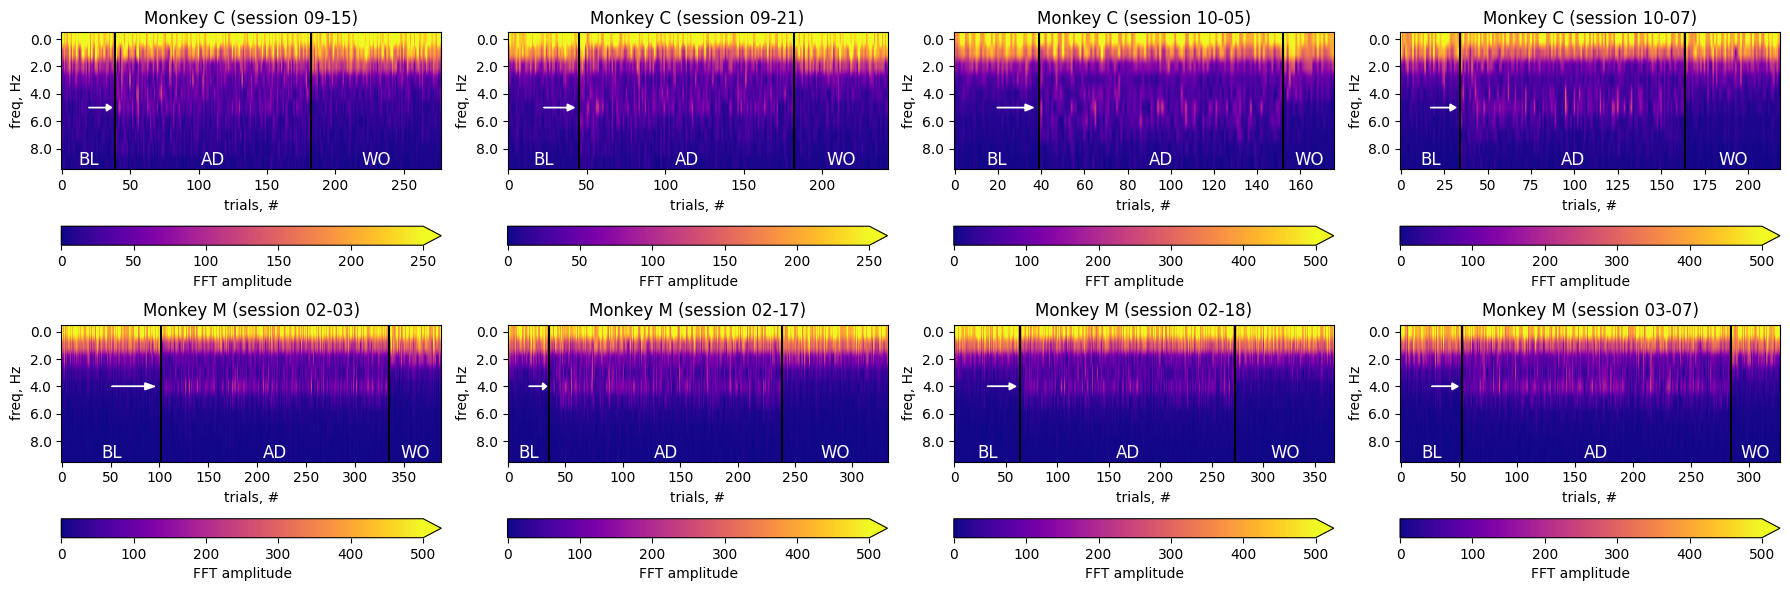

In [16]:

fig, axes = plt.subplots(2,4,figsize=(18,6))

for j, (m, exps, peak_fr) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]],[5,4])):
    for i,spike_data_dir in enumerate(exps):
        vmax = 250 if (j==0) & (i<2) else 500
        plot_fourier_last_sessions(axes[j,i], monkey=m, spike_data_dir=spike_data_dir, vel=Vel, epoch=Epoch, plot='spectrum', peak_freq = peak_fr, vmax=vmax)
        
plt.tight_layout()
fig.savefig('./figs/Figure3d_sup.pdf')

In [17]:
# load trial beginnings for angular deviation

# load all velocities for all sessions
Pos, Epoch_short, Target_short, Trial_short, Sign = {}, {}, {}, {}, {}
trial_len_short = 30

for spike_data_dir in experiments:
    
    pd_data = pyaldata.io.mat2dataframe(
        path=raw_data_dir + spike_data_dir, shift_idx_fields=True
    )

    # print(pd_data['idx_movement_on'].min(), pd_data['idx_movement_on'].max())

    # trials must be successful to be included
    selected_trials = pd_data.loc[
            (pd_data.result == "R") & (pd_data['idx_movement_on'] + trial_len_short < pd_data['idx_trial_end'])
        ]
    
    # selected_trials = pd_data.loc[(pd_data['idx_movement_on'] + trial_len < pd_data['idx_trial_end'])]

    # d[f'vel'][d.idx_trial_end - trial_len : d.idx_trial_end, :]

    perturb_info = np.array([d for d in selected_trials['perturbation_info'][:]])
    assert np.all(perturb_info == perturb_info[0]), "All trials must have the same perturbation info for this dataset."
    Sign[spike_data_dir] = np.sign(perturb_info[0,1])

    Pos[spike_data_dir] = np.asarray(
            [
                d[f'pos'][int(d.idx_movement_on) : int(d.idx_movement_on) + trial_len_short, :]
                for _, d in selected_trials.iterrows()
            ]
        )

    
    Target_short[spike_data_dir] = np.asarray(
            [
                d['target_direction']
                for _, d in selected_trials.iterrows()
            ]
        )
    
    Trial_short[spike_data_dir] = np.asarray(
            [
                d['trial_id']
                for _, d in selected_trials.iterrows()
            ]
        )
    
    # epoch (BL/AD/WO) for each trial
    Epoch_short[spike_data_dir] = np.asarray(
            [
                d['epoch']
                for _, d in selected_trials.iterrows()
            ]
        )

/disk/scratch/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/pandas/core/series.py:1033: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)
/disk/scratch/nkudryas/micromamba/envs/band-torch/lib/python3.9/site-packages/pandas/core/series.py:1033: RuntimeWarning: invalid value encountered in cast
  arr = np.asarray(values, dtype=dtype)


In [18]:
# plot_angular_deviation(axes[j,i], monkey=m, spike_data_dir=spike_data_dir, 
#       Pos=Pos, Sign=Sign, epoch=Epoch_short, target=Target_short,angle_t=29)

def plot_angular_deviation(ax, monkey, spike_data_dir, Pos, Sign, epoch, target, dt=0.01, angle_t=14):

    session = spike_data_dir.split('_')[3].split('.mat')[0][5:]
    epoch_args = {'fontsize': 12, 'ha': 'center'}

    # trial types are ordered in df
    AD_start = np.where(epoch[spike_data_dir]=='AD')[0][0]
    WO_start = np.where(epoch[spike_data_dir]=='WO')[0][0]

    P = Pos[spike_data_dir][:, :].copy() # get data for all trials, time point 80 onwards
    T = target[spike_data_dir][:].copy() # get target direction for all trials
    e = epoch[spike_data_dir][:].copy() # get epoch for all trials
    sign = Sign[spike_data_dir]

    print(sign)

    #center data   
    P -= P[:,0].mean(0)

    end_angles = np.arctan2(P[:,-1, 1], P[:,-1, 0])
    angles = np.arctan2(P[:,angle_t, 1], P[:,angle_t, 0])

    T_BL = T.copy()

    for t in np.unique(T):
        mask = (e=='BL') & (T==t)
        diff = ((end_angles[mask] - t + np.pi)%(2*np.pi)).mean() - np.pi
        T_BL[T==t] += diff

    dev = (sign*(angles-T_BL) + np.pi)%(2*np.pi) - np.pi

    if ax is None:
        return dev*180/np.pi
    else:
        ax.plot(dev*180/np.pi, label='Angular Deviation')
        ax.set_xlabel('trials, #')
        ax.set_title(f'Monkey {monkey} (session {session})')
        ax.axvline(AD_start,c='k')
        ax.axvline(WO_start,c='k')
    # ax.text(AD_start/2, epoch_y, 'BL', **epoch_args)
    # ax.text(AD_start+(WO_start-AD_start)/2, epoch_y, 'AD', **epoch_args)
    # ax.text(WO_start+(SR.shape[1]-WO_start)/2, epoch_y, 'WO', **epoch_args)

-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0


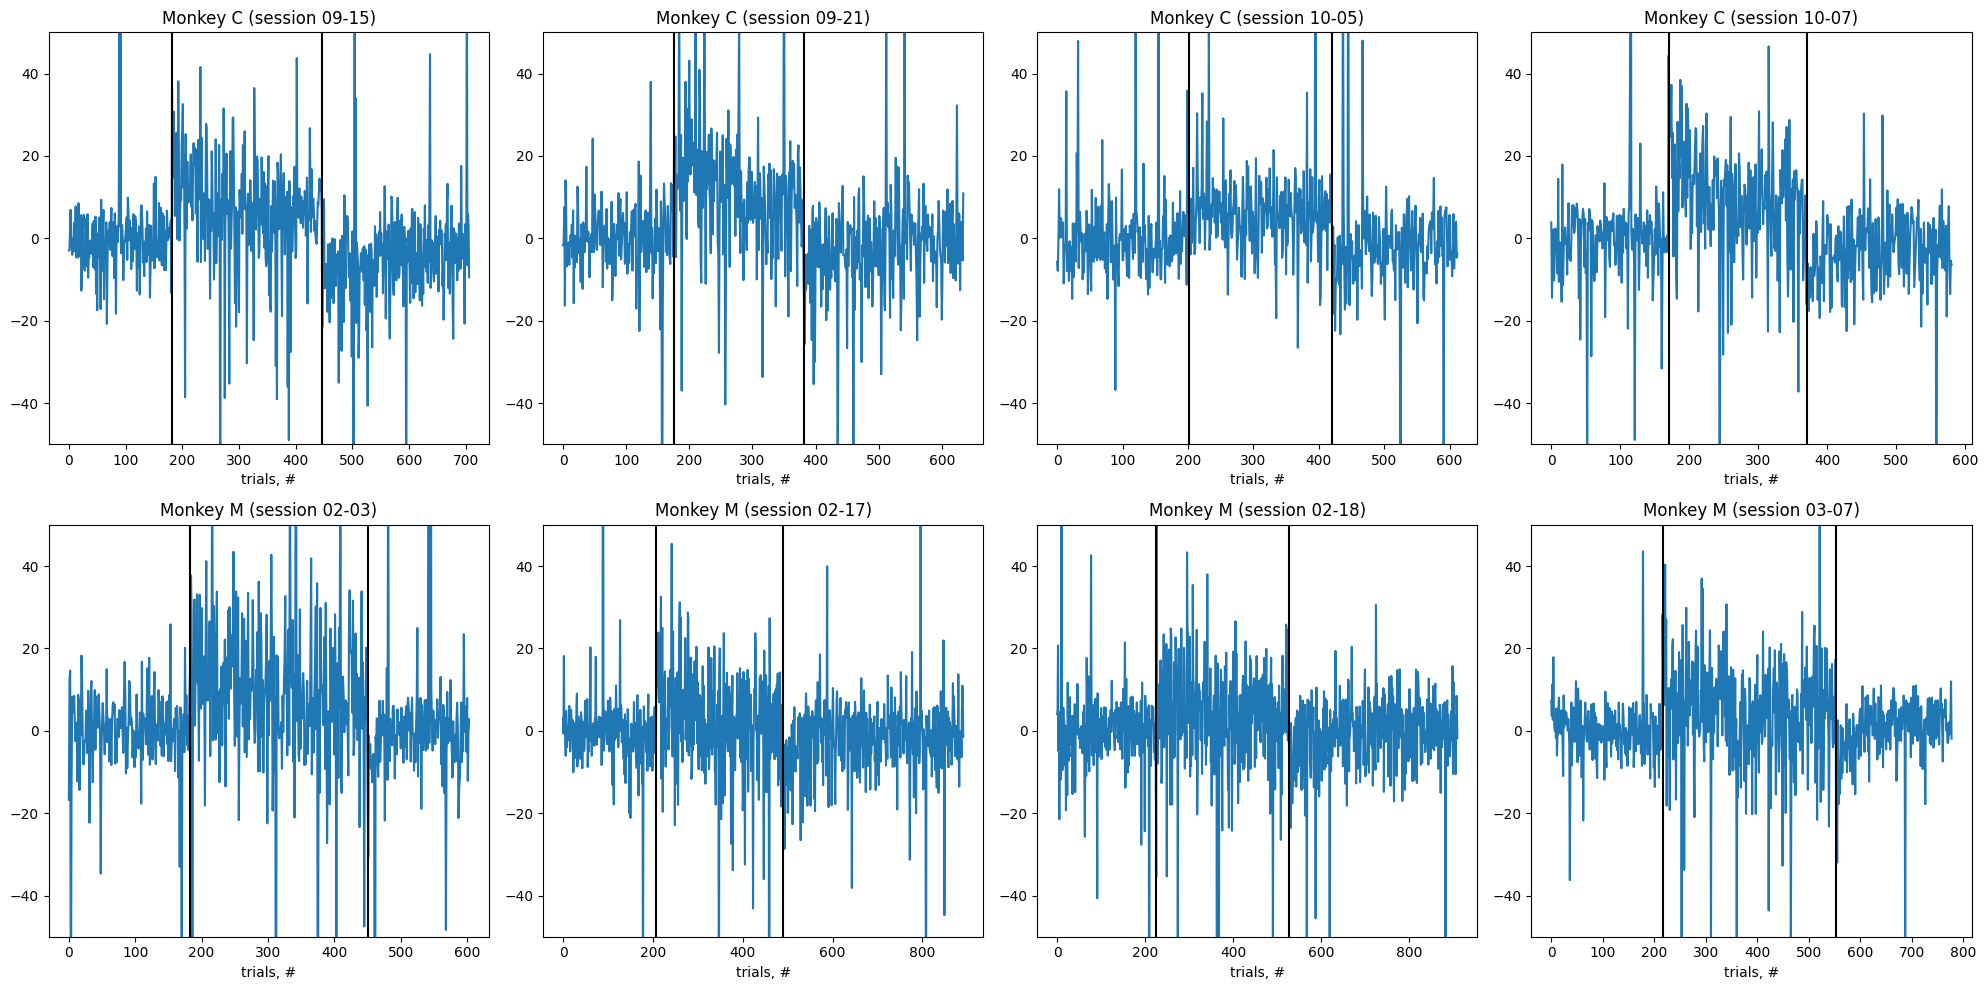

In [19]:

fig, axes = plt.subplots(2,4,figsize=(20,10))

for j, (m, exps, peak_fr) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]],[5,4])):
    for i,spike_data_dir in enumerate(exps):
        plot_angular_deviation(axes[j,i], monkey=m, spike_data_dir=spike_data_dir, Pos=Pos, Sign=Sign, epoch=Epoch_short, 
                               target=Target_short,angle_t=29)
        axes[j,i].set_ylim(-50,+50)

plt.tight_layout()
fig.savefig('./figs/Figure3f_sup.pdf')

-1.0
-1.0
1.0
-1.0
1.0
1.0
1.0
1.0


/tmp/ipykernel_78286/3003877081.py:35: RuntimeWarning: All-NaN slice encountered
  median_dev = np.nanmedian(collect_angle_data[m],axis=0)
/tmp/ipykernel_78286/3003877081.py:41: RuntimeWarning: All-NaN slice encountered
  median_dev_all = np.nanmedian(collect_all_plot_data,axis=0)


Text(750, -37, '100 trials')

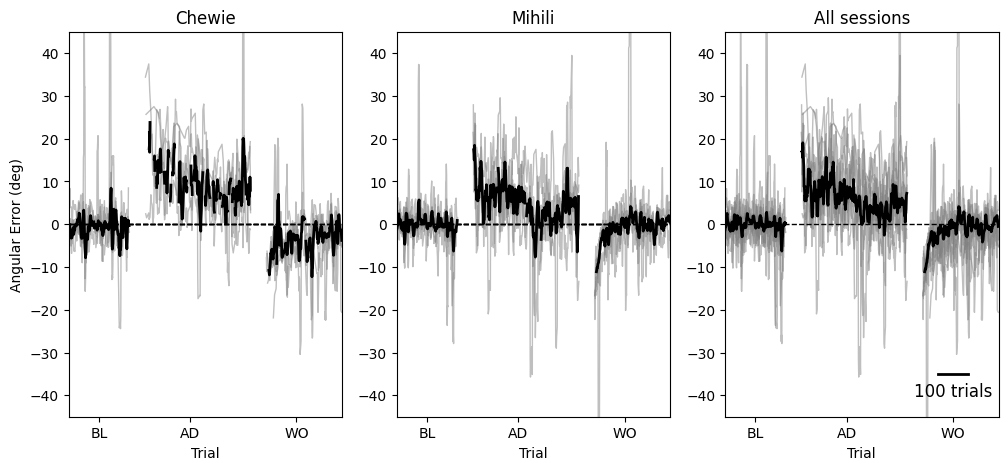

In [20]:
def get_trial_vector(spike_data_dir,T=Trial_short,E=Epoch_short):
    trial = T[spike_data_dir]
    epochs = E[spike_data_dir]
    trial_vector = np.zeros(epochs.shape[0]).astype(int)
    trial_vector[epochs=='BL'] = trial[epochs=='BL'] - trial[epochs=='BL'].max() + 200
    trial_vector[epochs=='AD'] = trial[epochs=='AD'] + 250
    trial_vector[epochs=='WO'] = trial[epochs=='WO'] + 650
    return trial, trial_vector

fig, axes = plt.subplots(1,3,figsize=(12,5))
collect_all_plot_data = np.ones([8,900]) * np.nan
collect_angle_data = {}
for j, (m, exps, angle_t) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]],[29,29])):
    ax = axes[j]
    collect_angle_data[m] = np.ones([4,900]) * np.nan
    for i,spike_data_dir in enumerate(exps):
        
        epochs = Epoch_short[spike_data_dir]
        dev = plot_angular_deviation(None, monkey=m, spike_data_dir=spike_data_dir, Pos=Pos, Sign=Sign, epoch=Epoch_short, target=Target_short, angle_t=angle_t)

        trial, trial_vector = get_trial_vector(spike_data_dir)
        for e in ['BL','AD','WO']:
            trial_lim = 350 if e=='AD' else 250
            smooth_dev = np.convolve(np.concatenate([dev[epochs==e][::-1],dev[epochs==e],dev[epochs==e][::-1]]), 
                                     np.ones(4)/4, mode='same')[len(dev[epochs==e]):2*len(dev[epochs==e])]
            ax.plot(trial_vector[(epochs==e) & (trial < trial_lim)],smooth_dev[trial[epochs==e] < trial_lim],lw=1,alpha=0.5,c='grey')
            axes[2].plot(trial_vector[(epochs==e) & (trial < trial_lim)],smooth_dev[trial[epochs==e] < trial_lim],lw=1,alpha=0.5,c='grey')
            collect_angle_data[m][i][trial_vector[(epochs==e) & (trial < trial_lim)]] = smooth_dev[trial[epochs==e] < trial_lim]
            collect_all_plot_data[i][trial_vector[(epochs==e) & (trial < trial_lim)]] = smooth_dev[trial[epochs==e] < trial_lim]

        ax.set_ylim([-45,45])
        ax.set_xlim([0,900])
        ax.axhline(0, c='k', ls='--', lw=1)

    median_dev = np.nanmedian(collect_angle_data[m],axis=0)
    # 4 trial moving average
    median_dev = np.convolve(np.concatenate([median_dev[::-1],median_dev,median_dev[::-1]]), 
                                            np.ones(4)/4, mode='same')[len(median_dev):2*len(median_dev)]
    ax.plot(median_dev, c='k', lw=2, label='median deviation')

median_dev_all = np.nanmedian(collect_all_plot_data,axis=0)
# 4 trial moving average
median_dev_all = np.convolve(np.concatenate([median_dev_all[::-1],median_dev_all,median_dev_all[::-1]]), 
                                            np.ones(4)/4, mode='same')[len(median_dev_all):2*len(median_dev_all)]
axes[2].plot(median_dev_all, c='k', lw=2, label='median deviation')
axes[2].set_ylim([-45,45])
axes[2].set_xlim([0,900])
axes[2].axhline(0, c='k', ls='--', lw=1)

axes[0].set_title('Chewie')
axes[1].set_title('Mihili')
axes[2].set_title('All sessions')
axes[0].set_ylabel('Angular Error (deg)')
for ax in axes:
    ax.set_xlabel('Trial')
    ax.set_xticks([100,400,750])
    ax.set_xticklabels(['BL','AD','WO'])

axes[2].plot([700, 800], [-35, -35], c='k', lw=2)
axes[2].text(750, -37, '100 trials', ha='center', va='top', fontsize=12)

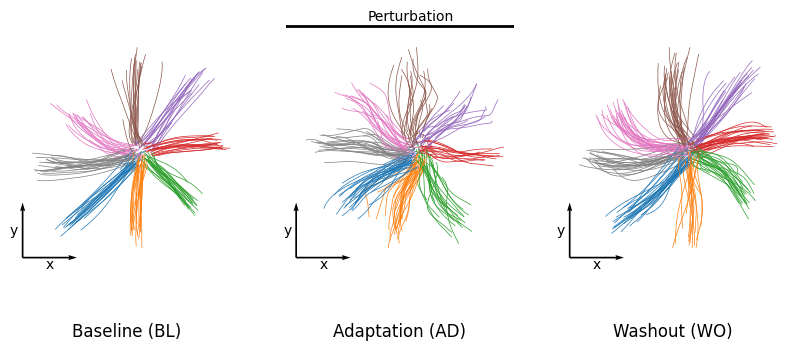

In [21]:
epochs_S = Epoch_short[experiments[3]]
target_direction_S = Target_short[experiments[3]]
epoch_index = (-1)*np.ones_like(epochs_S).astype(int)
for i, e in enumerate(['BL', 'AD', 'WO']):
    epoch_index[epochs_S == e] = i 
plot_directions_per_epoch(Pos[experiments[3]][:,:30],target_direction_S,epoch_index)

## Check reaction time of Chewie vs Mihili (unused)

Chewie_CO_FF_2016-09-15.mat 288.3453237410072
Chewie_CO_FF_2016-09-21.mat 310.12396694214874
Chewie_CO_FF_2016-10-05.mat 343.8068181818182
Chewie_CO_FF_2016-10-07.mat 316.80365296803654
Mihili_CO_FF_2014-02-03.mat 315.012853470437
Mihili_CO_FF_2014-02-17.mat 295.43806646525684
Mihili_CO_FF_2014-02-18.mat 311.4092140921409
Mihili_CO_FF_2014-03-07.mat 275.9633027522936


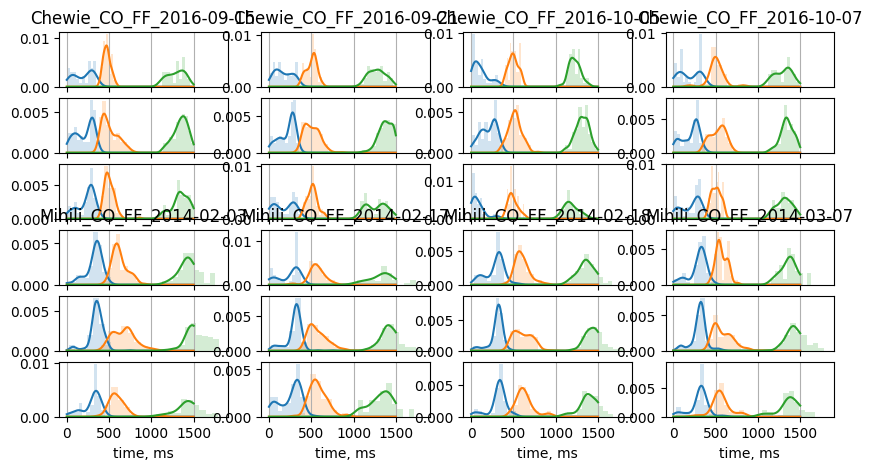

In [22]:
from scipy import stats

fig, axes = plt.subplots(2*3,4,figsize=(10,5),sharex=True)
for i, (m, exps) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]])):

    for j, exp in enumerate(exps):
        for k, e in enumerate(['BL','AD','WO']):

            ax = axes[i*3 + k,j]
            dels = 10*(idx_movement_on[exp]-idx_go_cue[exp])[Epoch[exp]==e]
            ax.hist(dels, density=True, color='C0',alpha=0.2)
            kde = stats.gaussian_kde(dels)
            xx = np.linspace(0, 1500, 200)
            ax.plot(xx,kde(xx), c='C0')

            dels = 10*(idx_peak_speed[exp]-idx_go_cue[exp])[Epoch[exp]==e]
            ax.hist(dels, density=True, color='C1',alpha=0.2)
            kde = stats.gaussian_kde(dels)
            xx = np.linspace(0, 1500, 200)
            ax.plot(xx,kde(xx), c='C1')

            dels = 10*(idx_trial_end[exp]-idx_go_cue[exp])[Epoch[exp]==e]
            ax.hist(dels, density=True, color='C2',alpha=0.2)
            kde = stats.gaussian_kde(dels)
            xx = np.linspace(0, 1500, 200)
            ax.plot(xx,kde(xx), c='C2')

            if k == 0:
                ax.set_title(exp.split('.mat')[0])
            if k == 2:
                ax.set_xlabel('time, ms')
            ax.grid(which='major', axis='x', zorder=-1.0)

        print(exp,np.mean(idx_peak_speed[exp]-idx_movement_on[exp])*10)
plt.savefig('time_progress.svg')

# Make figure layout

In [23]:
from goodman_panels import panels, panel_specs, label_panel, label_panels

[0.8462170983047688, 0.8384151357712967, 0.9065327688396823]


/tmp/ipykernel_78286/3385950468.py:89: RuntimeWarning: All-NaN slice encountered
  median_fft = np.nanmedian(collect_data,axis=0)
/tmp/ipykernel_78286/3385950468.py:92: RuntimeWarning: All-NaN slice encountered
  median_dev = np.nanmedian(collect_angle_data[m],axis=0)


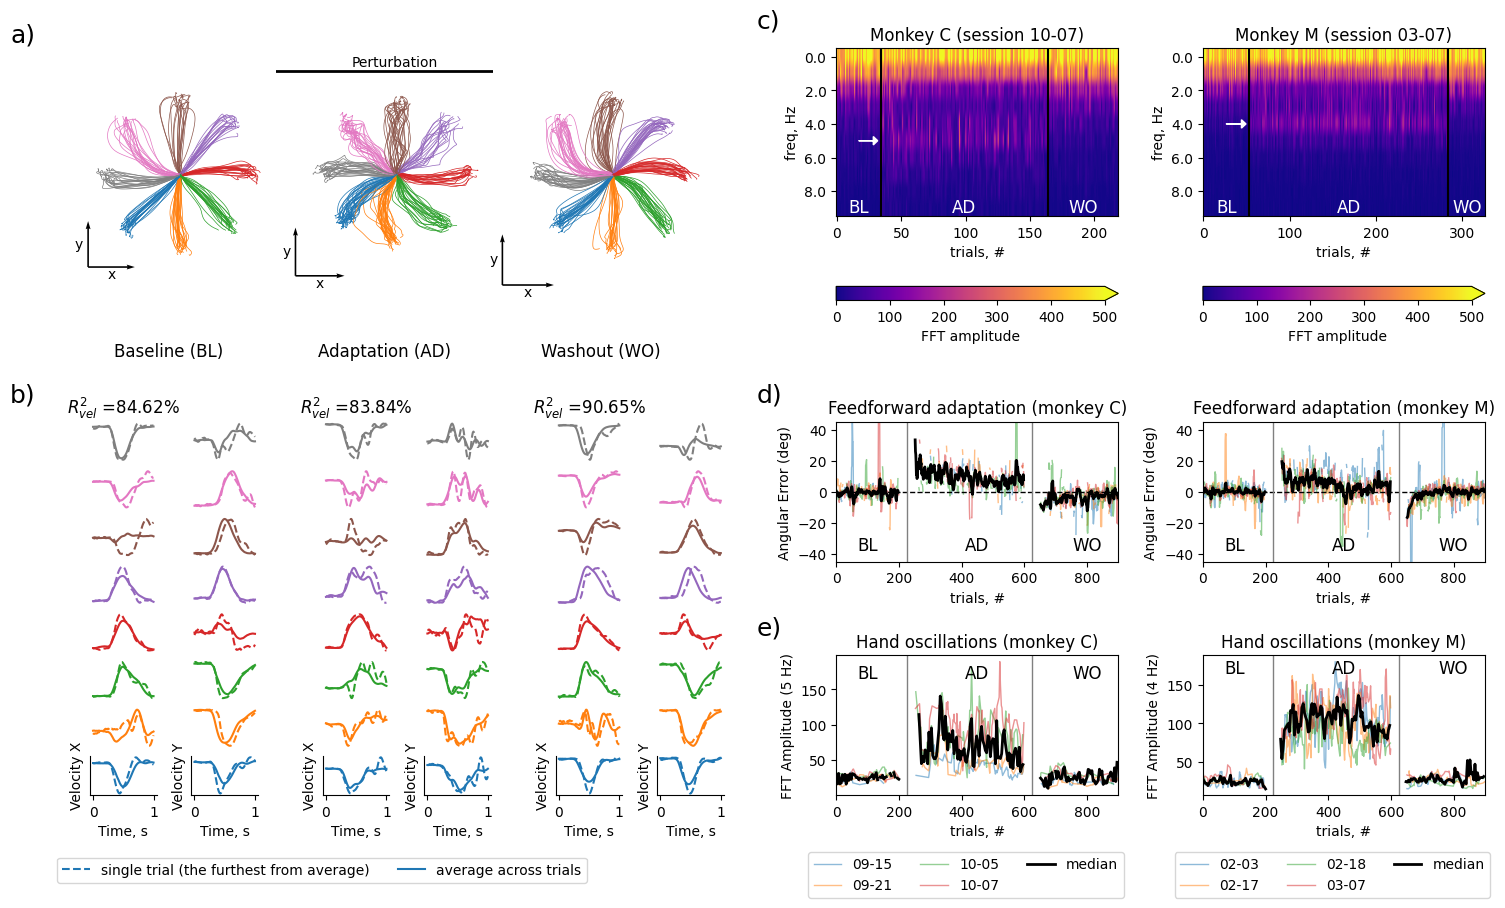

In [38]:
layout = '''
AC
BD
BE
'''
fig = plt.figure(figsize=(15, 9))
# blank = fig.add_subplot([0,0,1,1])
specs, gs = panel_specs(layout, fig=fig, gridspec_args={'left': 0.06, 'right': .99, 'bottom': 0.12, 'top': 0.95, 'hspace': .5, 'wspace': .15})
axes = {}
gs.set_width_ratios([1,1])
gs.set_height_ratios([2,1,1])

###############################################################

subgs = specs['A'].subgridspec(1, 3, wspace=0.0)
subgs.set_width_ratios([1, 1, 1])
for i in range(3):
    if i ==0:
        axes[f"A{i}"] = ax = fig.add_subplot(subgs[i],aspect=1.)
    else:
        axes[f"A{i}"] = ax = fig.add_subplot(subgs[i],aspect=1.,sharex=axes['A0'],sharey=axes['A0'])
    # manually move up
    p = ax.get_position()
    ax.set_position([p.x0-0.02, p.y0, p.width, p.height])
label_panel(axes['A0'], 'a', postfix=')',offset_up=0.4,offset_left=.5)

subgs = specs['B'].subgridspec(8, 6, wspace=.75)
for j in range(8):
    for i in range(6):
        axes[f"B{j}{i}"] = ax = fig.add_subplot(subgs[j,i])
        if i%2 == 1:
            # shift left
            ax_pos = ax.get_position()
            ax.set_position([ax_pos.x0-0.01, ax_pos.y0, ax_pos.width, ax_pos.height])
label_panel(axes['B00'], 'b', postfix=')')

ws = .3

subgs = specs['C'].subgridspec(1, 2, wspace=ws)
for j in range(2):
    axes[f"C{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['C0'], 'c', postfix=')')

subgs = specs['D'].subgridspec(1, 2, wspace=ws)
for j in range(2):
    axes[f"D{j}"] = ax = fig.add_subplot(subgs[j])
label_panel(axes['D0'], 'd', postfix=')')

subgs = specs['E'].subgridspec(1, 2, wspace=ws)
for j in range(2):
    axes[f"E{j}"] = ax = fig.add_subplot(subgs[j],sharex=axes[f'D{j}'])
label_panel(axes['E0'], 'e', postfix=')')

#################################################################

plot_directions_per_epoch(pos,target_direction,epoch,axes = [axes[f'A{i}'] for i in range(3)])

R2s = plot_beh_pred_per_epoch(vel[testQ==1], avg_vel_per_epoch[testQ==1], dir_index[testQ==1], trials2plot, epoch[testQ==1],component=0, ax_vel = [[axes[f'B{j}{i}'] for j in range(7,-1,-1)] for i in range(0,6,2)])
print(R2s)
plot_beh_pred_per_epoch(vel[testQ==1], avg_vel_per_epoch[testQ==1], dir_index[testQ==1], trials2plot, epoch[testQ==1],component=1, ax_vel = [[axes[f'B{j}{i}'] for j in range(7,-1,-1)] for i in range(1,6,2)])
for e in range(3):
    mask = epoch[testQ==1] == e
    axes[f'B0{2*e}'].set_title(r'$R^2_{vel}$ ='+f'{R2s[e]*100:.2f}%')
    axes[f'B0{2*e+1}'].set_title('')
axes[f'B70'].legend(['single trial (the furthest from average)','average across trials'], loc=(-.5,-2.2), ncols=2)

for i, (m, spike_data_dir, peak_fr) in enumerate(zip(['C','M'],[experiments[3],experiments[-1]],[5,4])):
    plot_fourier_last_sessions(axes[f'C{i}'], monkey=m, spike_data_dir=spike_data_dir, vel=Vel, epoch=Epoch, plot='spectrum', peak_freq = peak_fr)

for i, (m, exps, peak_fr) in enumerate(zip(['C','M'],[experiments[:4],experiments[4:]],[5,4])):
    collect_data = np.zeros([4,int(900/4)]) 
    for j,spike_data_dir in enumerate(exps):

        _, fft = plot_fourier_last_sessions(None, monkey=m, spike_data_dir=spike_data_dir, vel=Vel, epoch=Epoch, plot='top_freq', peak_freq = peak_fr, color='C3')
        trial, trial_vector = get_trial_vector(spike_data_dir,T=Trial,E=Epoch)
        epochs = Epoch[spike_data_dir]

        for e in ['BL','AD','WO']:
            trial_lim = 350 if e=='AD' else 250
            smooth_fft = np.convolve(np.concatenate([fft[epochs==e][::-1],fft[epochs==e],fft[epochs==e][::-1]]), 
                                        np.ones(4)/4, mode='same')[len(fft[epochs==e]):2*len(fft[epochs==e])]
            axes[f'E{i}'].plot(trial_vector[(epochs==e) & (trial < trial_lim)],
                            smooth_fft[trial[epochs==e] < trial_lim],lw=1,alpha=0.5,c=f'C{j}')
            collect_data[j][trial_vector[(epochs==e) & (trial < trial_lim)]//4] += smooth_fft[trial[epochs==e] < trial_lim]                
            
        axes[f'D{i}'].plot(collect_angle_data[m][j],c=f'C{j}', alpha=0.5, lw=1, label=spike_data_dir.split('_')[3].split('.mat')[0][5:])

    collect_data[collect_data==0] = np.nan
    median_fft = np.nanmedian(collect_data,axis=0)
    axes[f'E{i}'].plot(np.arange(len(median_fft))*4, median_fft, c='k', lw=2, label='median')

    median_dev = np.nanmedian(collect_angle_data[m],axis=0)
    mask = np.isnan(median_dev)
    median_dev[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), median_dev[~mask]) # fill a few missing trials in Chewie to match the scale of the plot above
    median_dev[-300:-250] = np.nan  # AD to WO gap
    median_dev[-700:-650] = np.nan  # BL to AD gap
    # 4 trial moving average
    median_dev = np.convolve(np.concatenate([median_dev[::-1],median_dev,median_dev[::-1]]), 
                                            np.ones(4)/4, mode='same')[len(median_dev):2*len(median_dev)]
    axes[f'D{i}'].plot(median_dev, c='k', lw=2, label='median')

    
    axes[f'D{i}'].set_xlabel('trials, #')
    axes[f'E{i}'].set_ylabel(f'FFT Amplitude ({peak_fr} Hz)')
    axes[f'D{i}'].set_ylabel('Angular Error (deg)')
    axes[f'D{i}'].axhline(0, c='k', ls='--', lw=1)
    axes[f'D{i}'].legend(loc = (-.1,-2.4), ncols=3)
    axes[f'D{i}'].set_ylim([-45,45])
    axes[f'D{i}'].set_yticks([-40,-20,0,20,40])
    axes[f'E{i}'].set_title(f'Hand oscillations (monkey {m})')
    axes[f'D{i}'].set_title(f'Feedforward adaptation (monkey {m})')
    
    for letter,level in zip(['D','E'],[-40,160]):
        axes[f'{letter}{i}'].set_xlabel('trials, #')
        axes[f'{letter}{i}'].set_xlim([0,900])
        axes[f'{letter}{i}'].text(100, level , 'BL', fontsize=12, ha='center', va='bottom')
        axes[f'{letter}{i}'].text(450, level , 'AD', fontsize=12, ha='center', va='bottom')
        axes[f'{letter}{i}'].text(800, level , 'WO', fontsize=12, ha='center', va='bottom')
        axes[f'{letter}{i}'].axvline(225, c='grey', lw=1)
        axes[f'{letter}{i}'].axvline(625, c='grey', lw=1)

fig.savefig('./figs/Figure2.pdf')